# SWDB - Day 5, Tutorial 1
## History dependent prediction/ regression models for neural dynamics
- How interaction among neurons give rise to their activity patterns
- Inverstigate the temporal dependence of neural dynamics on the events happening previously
- How far back do previous events influence the activity in the future
- Tease apart the contribution to neural activity from current stimulus and previous activity
- (TODO) Add references (Posterior parietal cortex represents sensory history and mediates its effects on behaviour)

### Imports

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import allensdk

allensdk.__version__

'2.15.2'

### Load Data

In [3]:
# Code Ocean
manifest_path = '/data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json' 
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Walker lab server
# download/ load the data set
# output_dir = "/src/swdb_2023/Day5/data"
# this path determines where downloaded data will be stored
# manifest_path = os.path.join(output_dir, "manifest.json")
# cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


### Only interested in brain observatory data

TODO: check/ switch to functional connectivity dataset as Koosha suggested

In [4]:
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
brain_observatory_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
791319847,2019-10-03T00:00:00Z,769360779,brain_observatory_1.1,116.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,555,2229,6,"[APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,..."
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
798911424,2019-10-03T00:00:00Z,775876828,brain_observatory_1.1,110.0,F,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,825,2233,6,"[APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n..."
799864342,2019-10-03T00:00:00Z,772616823,brain_observatory_1.1,129.0,M,wt/wt,604,2233,6,"[APN, POL, LP, DG, CA1, VISrl, nan, LGd, CA3, ..."


### Choose a random session, examine

In [5]:
session_id = 791319847
session = cache.get_session_data(session_id)

In [6]:
# plot number of neurons per region
session.structurewise_unit_counts

VISp     93
CA1      85
VISrl    58
VISl     56
VISam    49
VISal    43
SUB      41
CA3      33
DG       32
VISpm    17
LGv      16
LP        9
LGd       8
TH        4
ZI        4
CA2       3
POL       3
ProS      1
Name: ecephys_structure_acronym, dtype: int64

### Look only at drifting gratings stims

In [7]:
session.get_stimulus_table(["drifting_gratings"])

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,90.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1590.469172,2.0,drifting_gratings,1592.470862,15.0,2.00169,246
3799,0.8,135.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1593.471657,2.0,drifting_gratings,1595.473327,4.0,2.00167,247
3800,0.8,135.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1596.474152,2.0,drifting_gratings,1598.475832,2.0,2.00168,248
3801,0.8,0.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1599.476677,2.0,drifting_gratings,1601.478347,1.0,2.00167,249
3802,0.8,225.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1602.479182,2.0,drifting_gratings,1604.480862,1.0,2.00168,250
...,...,...,...,...,...,...,...,...,...,...,...,...
49428,0.8,90.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5388.643497,7.0,drifting_gratings,5390.645187,1.0,2.00169,259
49429,0.8,270.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5391.646002,7.0,drifting_gratings,5393.647682,4.0,2.00168,270
49430,0.8,270.0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5394.648527,7.0,drifting_gratings,5396.650207,4.0,2.00168,270


### Load spike data
- Here, we'll load the spike data for each trial, aligned to the stimulus onset. We'll choose a trial interval 100ms before stimulus onset to 500ms after, counting spike counts in 50ms time bins. 
- One way to visualize these spike counts is through a heat map, which is shown below. 

In [8]:
presentations = session.get_stimulus_table("drifting_gratings")
# filter out "null trials"
presentations = presentations[presentations.orientation != 'null']
units = session.units[session.units["ecephys_structure_acronym"] == 'VISp']

time_step = 0.05
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=units.index.values
)

# grab distinct orientations (directions)
unique_orientations = presentations.orientation.unique()
unique_orientations.sort()

### Plot firing rate of each VISp neuron (averaged across stim presentations), aligned on stimulus onset

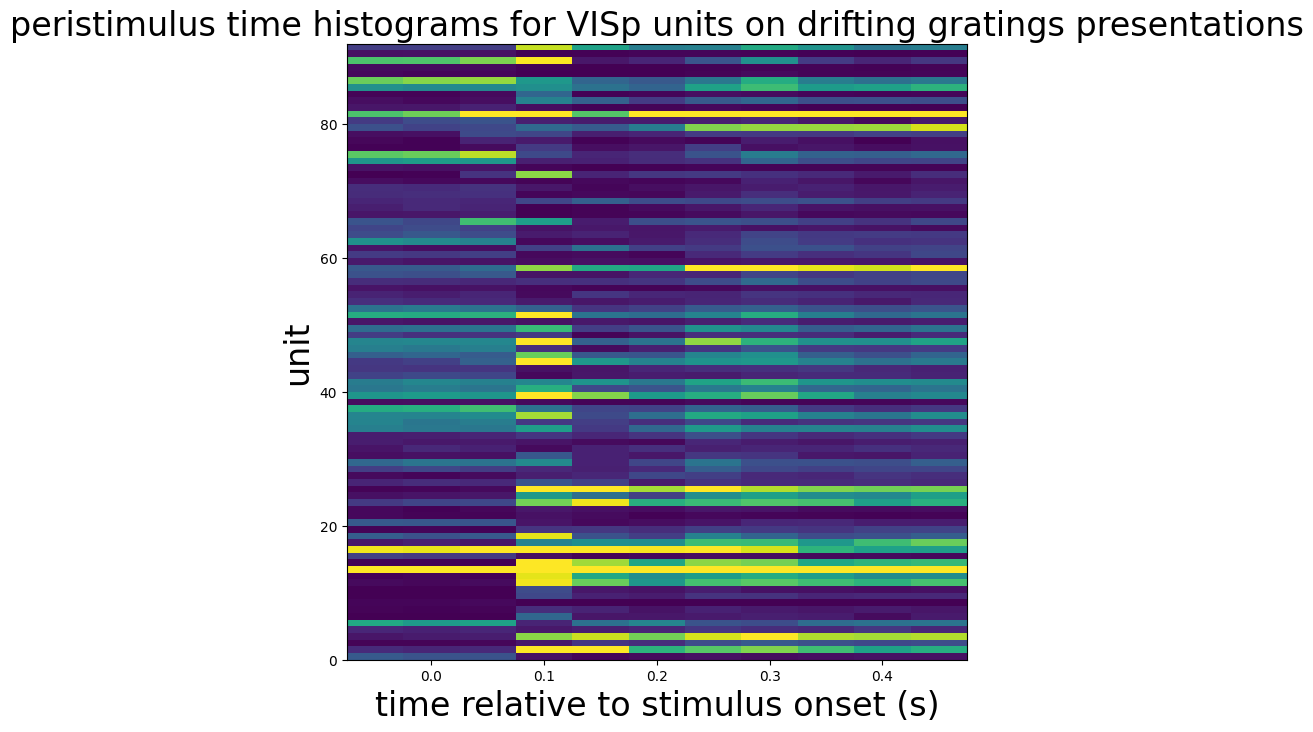

In [9]:
mean_spikes = spikes.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_spikes["time_relative_to_stimulus_onset"], 
    np.arange(mean_spikes["unit_id"].size),
    mean_spikes.T, 
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on drifting gratings presentations", fontsize=24)

plt.show()

### Look at firing rate of specific neurons, split by grating orientation
- How much do differences in the presented stimuli explain neural variability?
- In this case, stimuli vary in their direction of grating, so to investigate, we can plot the spike counts of a few units as a function of time, averaged across stimulus grating directions

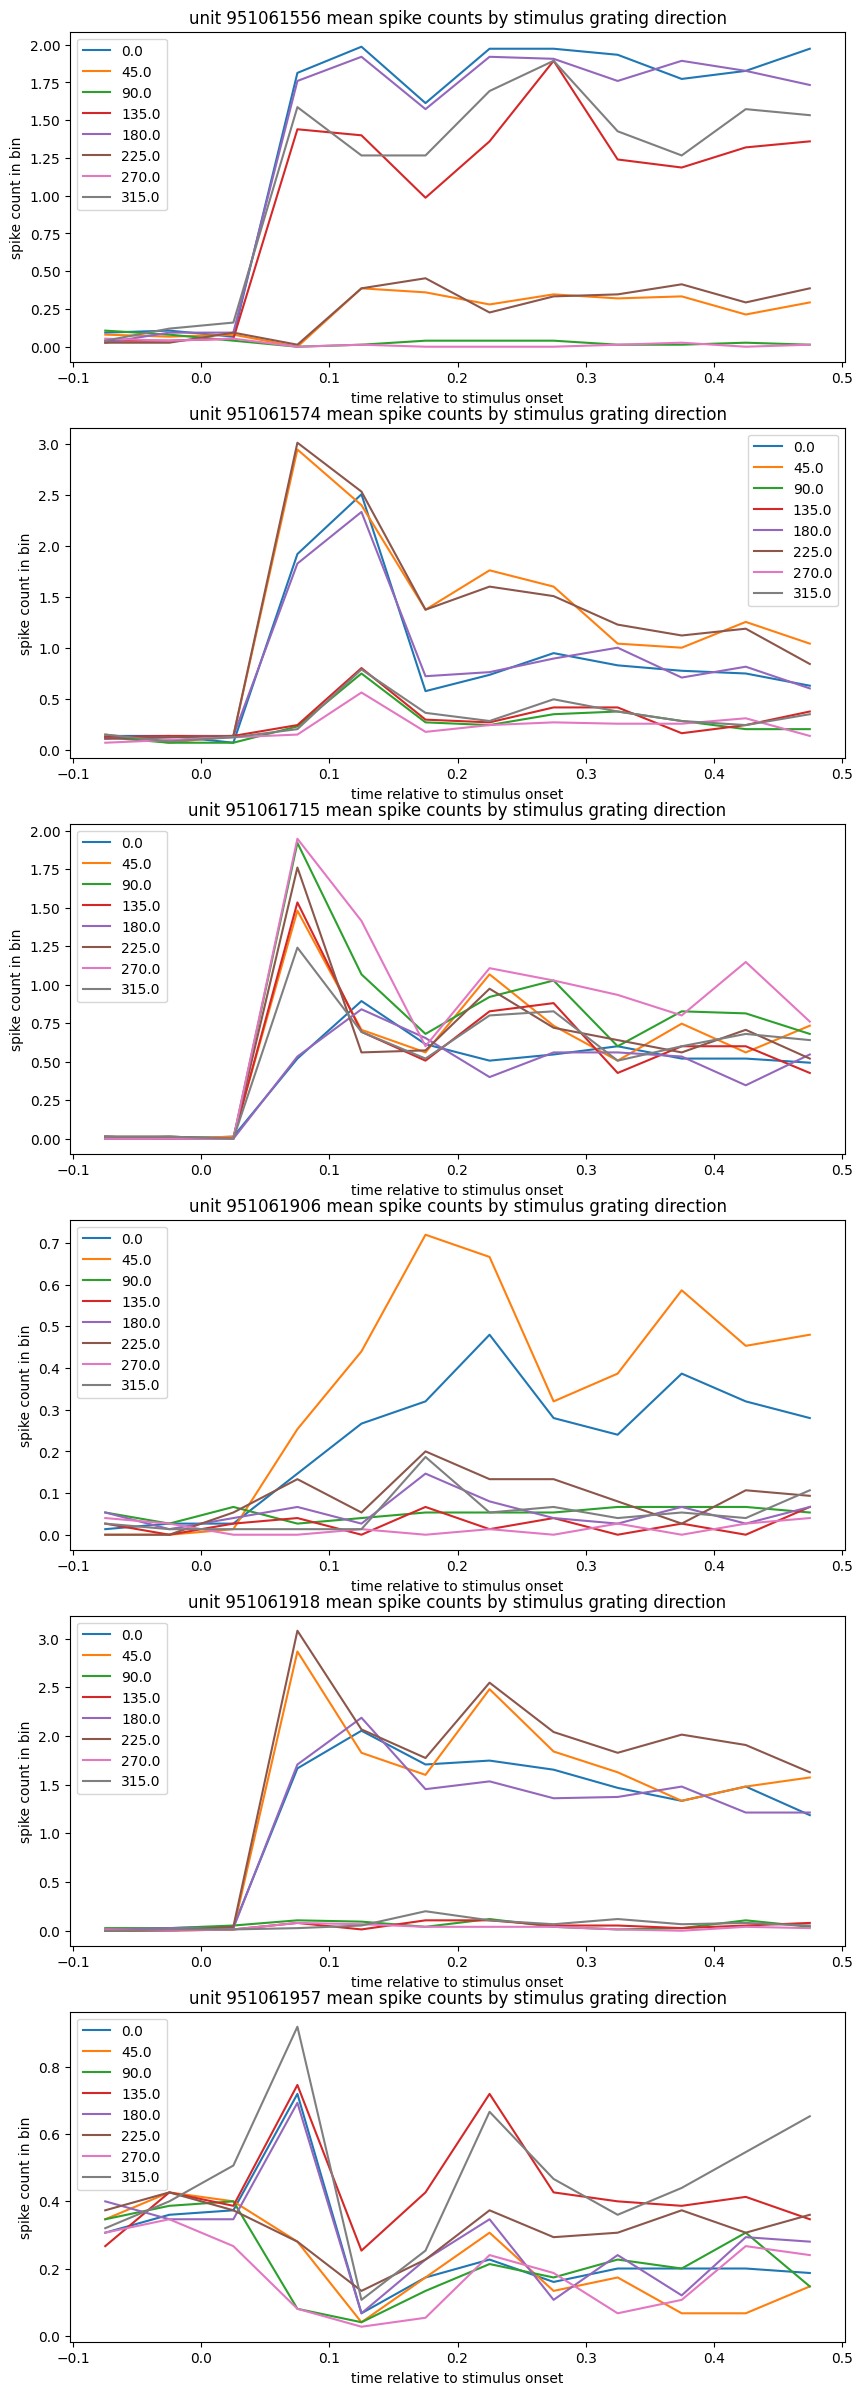

In [10]:
# for each unit, make plots of averaged responses across each orientation, aligned to stim onset

# a list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
fig, ax = plt.subplots(len(interesting_units), 1, figsize=(10, 30))

for i, unit_id in enumerate(interesting_units):
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = spikes.loc[trial_ids, :, unit_id]
        mean = data.mean(dim="stimulus_presentation_id")
        ax[i].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    ax[i].legend()
    ax[i].set_xlabel("time relative to stimulus onset")
    ax[i].set_ylabel("spike count in bin")
    ax[i].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


## Focus on Unit 951061556
- Focusing on just a single unit for a moment, what is a good model for explaining neural activity?

## Prep for models
First, we can do some setup. Here we:
- Define a helper function to calculate $r^2$, which will give us a metric for how much variability our models are explaining
- Split our trials into train/test sets, which allows us to evaluate how well our models can generalize to data not used during training

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


def calc_r_squared(y_true, y_pred):
    """
    Calculates r^2 metric for true vs predicted labels
    NOTE: could also use .score() from sklearn LinearRegression here, but it's a bit unfitting since
    we'd want to evaluate r^2 for all time points, but are sometimes training different models for each time point. 
    Args: 
        y_true, y_pred of any shape
    """
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(((y_true - y_true.mean()) ** 2))


def get_one_hot_encoding(orientations):
    """
    Generates a one-hot-encoding of stimulus directions
    Args: 
        orientations: an array of orientations as degrees, of length n_trials. Assumes that
            orientations are in 45 degree increments, with 8 unique values. 
    Returns: 
        an array of shape n_trials x 8. array has values either 0 or 1, with one 1 existing per row, 
            indicating which orientations was present for that trial. 
    """
    one_hot = np.zeros((len(orientations), 8))
    orientation_idxs = (orientations / 45).astype(int)
    one_hot[np.arange(len(orientation_idxs)), orientation_idxs] = 1
    return one_hot


In [12]:
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)

unit_id = 951061556
orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = spikes.loc[train_idxs, :, unit_id].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = spikes.loc[test_idxs, :, unit_id].values

## Stimulus-based regression model. 
One simplified first model is to assume that neural response depends linearly on the stimulus direction, and this dependency not vary with respect to time. 
$$ r(t) = \textbf{w}^{stim} \cdot \textbf{s} $$
Where r(t) is neuron's activity, $ \textbf{w}^{stim} $ is a vector of weights that will be fit, and $\textbf{s}$ is a one-hot encoding vector stimulus direction. 

**Note**
- Here we have chosen to represent our stimulus as one-hot vectors of 8 different directions. We could have alternatively treated the stimulus as a single continuous variable, with our model being: $ r(t) = w^{stim} \cdot s $. What are the benefits/drawbacks of each choice?

In [13]:
num_time_steps = spikes_train.shape[1]
X_train = get_one_hot_encoding(orientations_train).repeat(num_time_steps, axis=0)
# X_train = orientations_train.repeat(num_time_steps).reshape(-1, 1)
Y_train = spikes_train.flatten()
X_test = get_one_hot_encoding(orientations_test).repeat(num_time_steps, axis=0)
# X_test = orientations_test.repeat(num_time_steps).reshape(-1, 1)
Y_test = spikes_test.flatten()

reg = LinearRegression()
reg.fit(X_train, Y_train)

train_score = calc_r_squared(Y_train, reg.predict(X_train))
test_score = calc_r_squared(Y_test, reg.predict(X_test))
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.29205329475868436
Test Score: 0.28433435880914315


## Plot what the model predictions look like for test trials
Now that we have trained our model for this neuron's response, we can see what it's predictions look like against the stimulus-averaged true responses

Text(0.5, 1.0, 'unit 951061556 mean spike counts by stimulus grating direction')

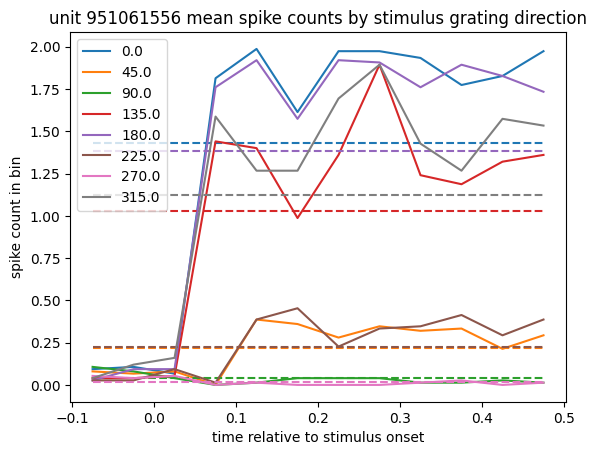

In [14]:
# plot regression result
unique_orientations.sort()
unit_id = 951061556

fig, ax = plt.subplots()

for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    predictions = reg.predict(get_one_hot_encoding(np.array([orientation]).repeat(num_time_steps)))
    ax.plot(data["time_relative_to_stimulus_onset"], predictions, color=line.get_color(), linestyle="--")
ax.legend()
ax.set_xlabel("time relative to stimulus onset")
ax.set_ylabel("spike count in bin")
ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

Text(0.5, 1.0, 'unit 951061556 tuning curve by stimulus grating direction')

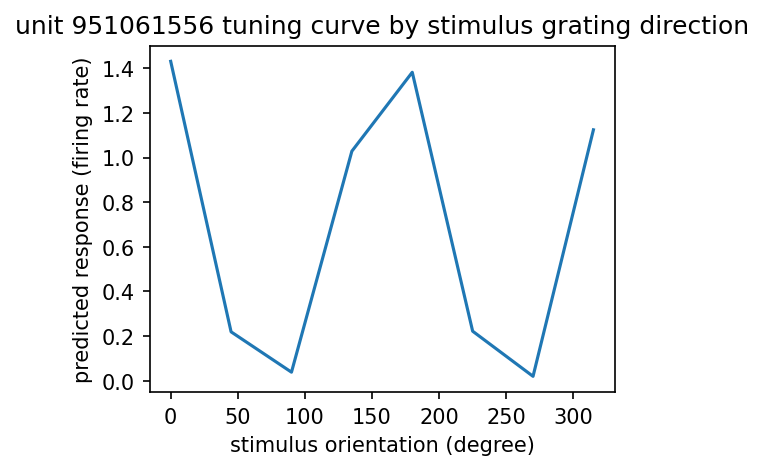

In [23]:
# link to tuning curve
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
predictions = []
for orientation in unique_orientations: 
    prediction = reg.predict(get_one_hot_encoding(np.array([orientation]).repeat(num_time_steps)))[0]
    predictions.append(prediction)
ax.plot(unique_orientations, predictions)
ax.set_xlabel("stimulus orientation (degree)")
ax.set_ylabel("predicted response (firing rate)")
ax.set_title(f"unit {unit_id} tuning curve by stimulus grating direction")

### Observation
unit 951061556 is an orientation-selective unit instead of a direction-selective one, and most sensitive to horizontal gratings (equally responsive to 0, 180, 360-degree gratings)

## Stimulus based regression with varying weights
The previous model made the simpifying assumption that stimulus direction's contribution to neural response is constant across the course of a trial, hence was only able to predict constant responses across time. What if we loosened this assumption a bit, and fit a separate regression per-time-bin? Our model now becomes: 
$$ r(t) = \textbf{w}^{stim}(t) \cdot \textbf{s} $$
Where: 
- $ \textbf{w}^{stim} $ is still a vector of learned weights, but it will vary by time bin
- $ \textbf{s} $ is still one-hot encoding vector stimulus direction. This has no time component as the stimulus direction does not change within a trial. 
In this case, training models separately per time bin

### Train models

In [25]:
lin_reg_results = []
Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    reg = LinearRegression()
    X_train = get_one_hot_encoding(orientations_train)
    Y_train = spikes_train[:, i]

    X_test = get_one_hot_encoding(orientations_test)

    reg.fit(X_train, Y_train)

    lin_reg_results.append(reg)    
    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))


### Evaluate train and test scores

In [26]:
train_score = calc_r_squared(spikes_train, np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test, np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.5120568812347003
Test Score: 0.497783412614355


### Visualize regression results, compare to per stim averaged by timebin

Text(0.5, 1.0, 'unit 951061556 mean spike counts by stimulus grating direction')

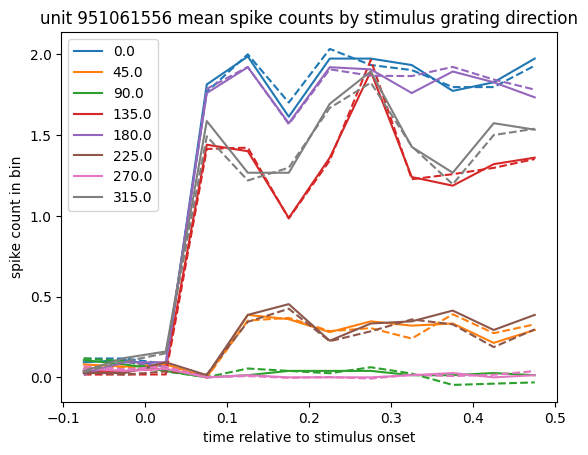

In [27]:
# plot regression result
fig, ax = plt.subplots()

for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    predictions = [reg.predict(get_one_hot_encoding(np.array([orientation]))) for reg in lin_reg_results]
    ax.plot(data["time_relative_to_stimulus_onset"], predictions, color=line.get_color(), linestyle="--")
ax.legend()
ax.set_xlabel("time relative to stimulus onset")
ax.set_ylabel("spike count in bin")
ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

## What about the rest of the variability?
So far, our model has gotten fairly good at matching the stimulus-averaged responses of this neuron, though looking at the $ R^2 $ score this still doesn't explain all of the neural variability. How variable is neuron's activity within the same stimulus condition?

To answer this question, we can plot the per-trial activity of our neuron within the same stimulus condition (direction grating at 0 degrees). For visualization purposes, we'll bin the neural activity at 5ms bins, and smooth it over a 50ms window. 

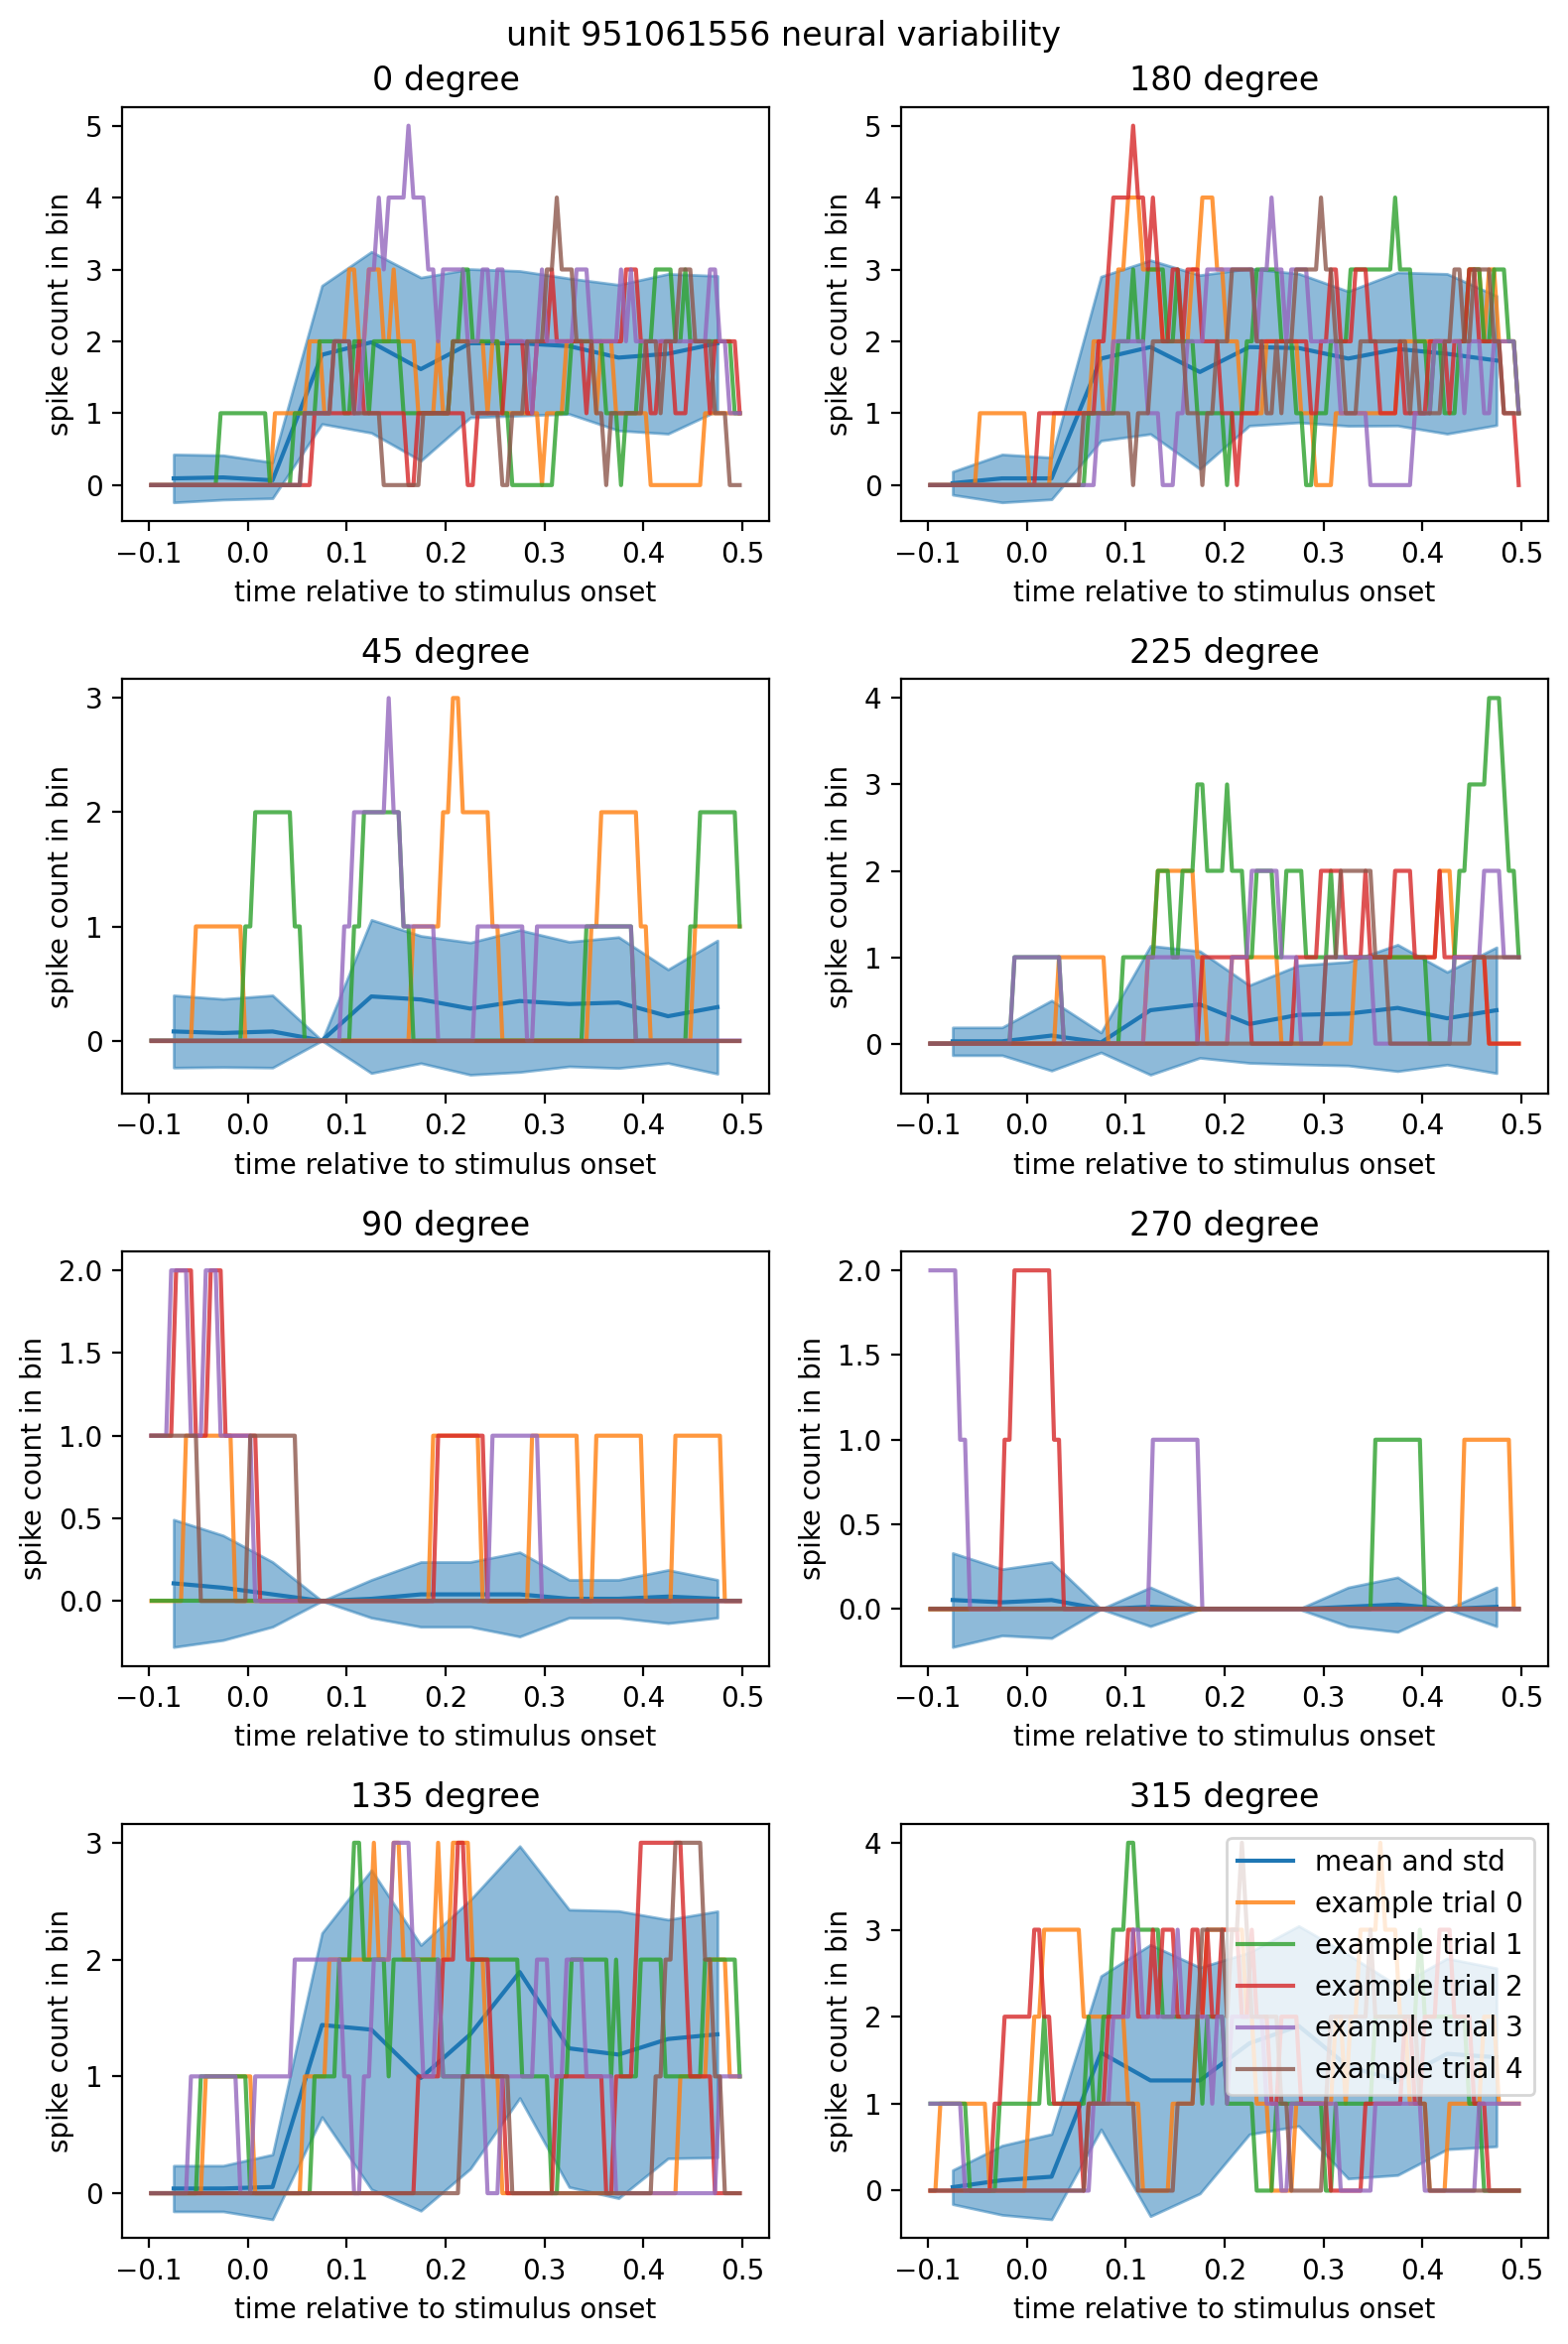

In [51]:
unit_id = 951061556
time_step = 0.005
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

num_example_trials_to_plot = 5
fig, axs = plt.subplots(4,2, figsize=(8,12), dpi=200)

for orientation_id, orientation in enumerate(unique_orientations):
    row = int(orientation_id% 4)
    col = int(orientation_id/ 4)
    ax = axs[row, col]
    
    trial_ids = presentations[presentations.orientation == orientation].index.values 
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    mean_line, = ax.plot(data["time_relative_to_stimulus_onset"], mean, label="mean and std")
    std = data.std(dim="stimulus_presentation_id")
    std_line = ax.fill_between(data["time_relative_to_stimulus_onset"], mean - std, mean + std, color=mean_line.get_color(), alpha=0.5)
    spikes_viz = session.presentationwise_spike_counts(
                        stimulus_presentation_ids=presentations.index.values,  
                        bin_edges=time_bins,
                        unit_ids=units.index.values).loc[trial_ids, :, unit_id]

    for i in range(num_example_trials_to_plot):
        smoothed = np.convolve(spikes_viz[i, :], np.ones(10) / 10 , mode='same') * 10
        ax.plot(spikes_viz["time_relative_to_stimulus_onset"], smoothed, label=f"example trial {i}", alpha=0.8)
        
    #ax.legend()
    ax.set_xlabel("time relative to stimulus onset")
    ax.set_ylabel("spike count in bin")
    ax.set_title(f"{int(orientation)} degree")

plt.legend()    
fig.suptitle(f"unit {unit_id} neural variability")
fig.tight_layout()

## stimulus + 1 time bin back regression

$$ r(t) = w^{stim}(t) \times s + w^{auto}_{t-1}(t) \times r(t-1) $$

Per timestep, is variation in activity explained by stim direction as well as previous activity?

In [73]:
def get_X_auto_reg(spikes, orientations, i, lag=1):
    """
    Generates a input data matrix for the lag time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
    """
    orientations_one_hot = get_one_hot_encoding(orientations)
    spikes_design_matrix = spikes[:, i-lag:i]
    
    return np.concatenate([orientations_one_hot, spikes_design_matrix], axis=1)


auto_reg_results = []
Y_train_preds = []
Y_test_preds = []
for i in range(spikes_train.shape[1]):
    if i >= 1:
        reg = LinearRegression()
        X_train = get_X_auto_reg(spikes_train, orientations_train, i)
        X_test = get_X_auto_reg(spikes_test, orientations_test, i)

        Y_train = spikes_train[:, i]
        reg.fit(X_train, Y_train)
        auto_reg_results.append(reg)

        Y_train_preds.append(reg.predict(X_train))
        Y_test_preds.append(reg.predict(X_test))

In [74]:
train_score = calc_r_squared(spikes_train[:, 1:], np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test[:, 1:], np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.5472095189987949
Test Score: 0.5215768729177885


### Observation
Autoregressive models with 1 time-bin back history add slight improvements to the r2 score (from 0.49 to 0.52 on the test set.)

In [ ]:
# TODO!: how to visual the result of autoregressive models?
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), len(auto_reg_results)))
for i, res in enumerate(auto_reg_results):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = spikes.loc[trial_ids, :, unit_id]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg(data, orientations, time_bin_idx)
        Y = res.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression")

## Same autoregressive model, but what if we added more lag?

$$ r(t) = w^{stim}(t) \times s + \sum_{i=1}^T w^{auto}_{t-i}(t) \times r(t-i) $$

How do scores vary with choice of lag L we choose?

In [84]:
train_scores = []
test_scores = []
auto_reg_results = {}

for n_lag in range(0, 8):
    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []
    
    for time_idx in range(spikes_train.shape[1]):
        if time_idx >= n_lag:
            reg = LinearRegression()
            X_train = get_X_auto_reg(spikes_train, orientations_train, time_idx, lag=n_lag)
            #print(f'lag {n_lag}: time_idx {time_idx}, shape {X_train.shape}')
            X_test = get_X_auto_reg(spikes_test, orientations_test, time_idx, lag=n_lag)

            Y_train = spikes_train[:, time_idx]
            reg.fit(X_train, Y_train)
            auto_reg_fits.append(reg)

            Y_train_preds.append(reg.predict(X_train))
            Y_test_preds.append(reg.predict(X_test))
            
    # evaluate bin index [n_lag: )
    train_score = calc_r_squared(spikes_train[:, n_lag:], np.vstack(Y_train_preds).T)
    test_score = calc_r_squared(spikes_test[:, n_lag:], np.vstack(Y_test_preds).T)
    train_scores.append(train_score)
    test_scores.append(test_score)
    auto_reg_results[n_lag] = auto_reg_fits

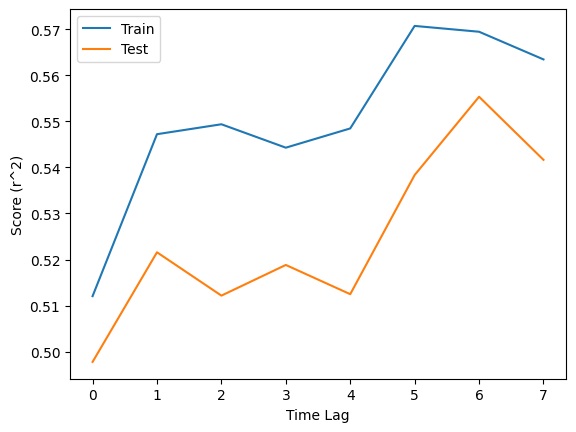

In [85]:
fig, ax = plt.subplots()
ax.plot(range(0, 8), train_scores, label="Train")
ax.plot(range(0, 8), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score (r^2)")
ax.legend()

### Observation
adding more lags to the autoregressive models may increases the r2 score. In this unit, with n_lag=6 we have the best model with r2 score up to 0.55 in the test set.

## How do auto-regressive coefficients change over the course of a trial?

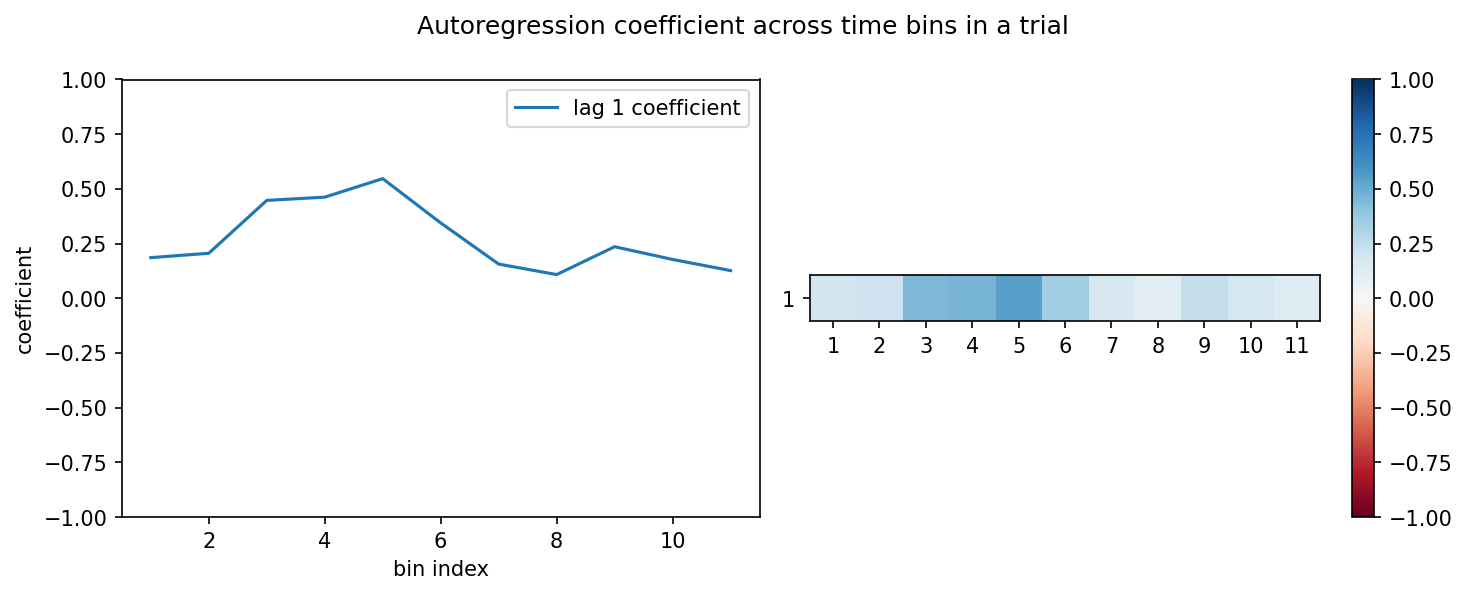

In [91]:
# use time_lag=1 model as an exmaple

lag_model = 1
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[8:])
reg_coeff = np.array(reg_coeff)

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

ax = axs[0]
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j} coefficient')
ax.set_ylim(-1, 1)
ax.set_xlabel("bin index")
ax.set_ylabel("coefficient")
ax.legend()

ax = axs[1]
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))

fig.suptitle("Autoregression coefficient across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

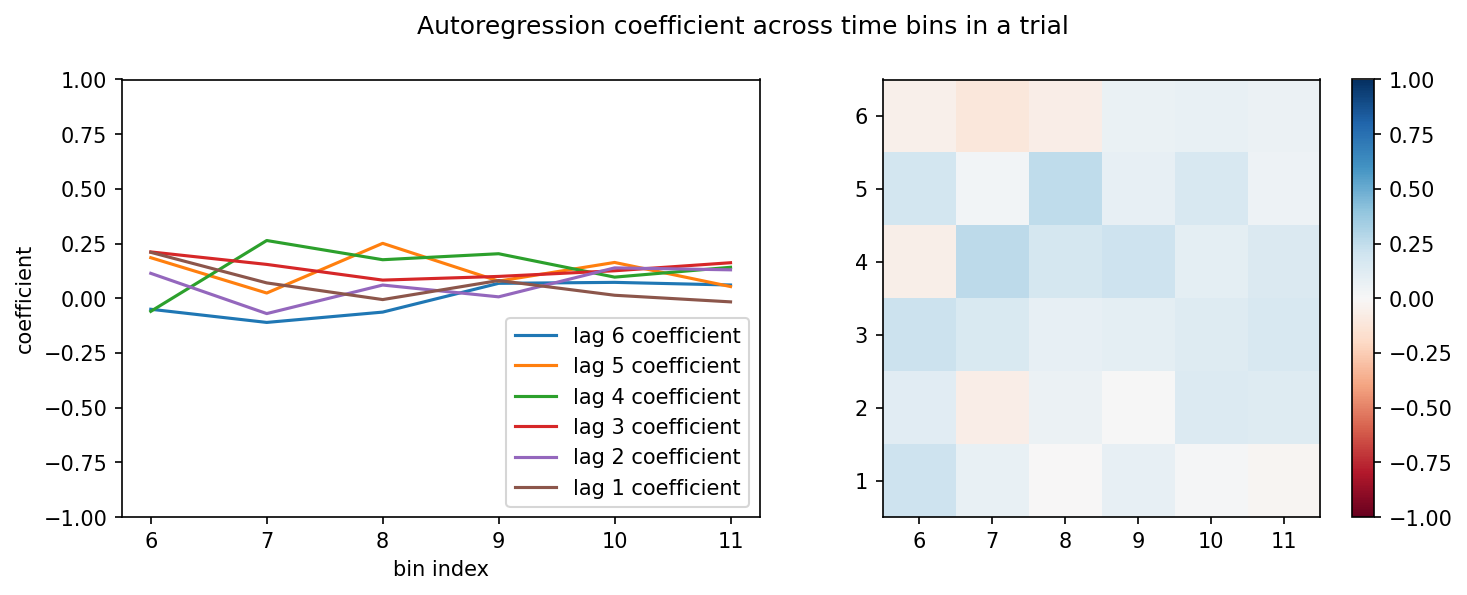

In [95]:
# use time_lag=6 model as an exmaple

lag_model = 6
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[8:])
reg_coeff = np.array(reg_coeff)


# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

ax = axs[0]
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j} coefficient')
ax.set_ylim(-1, 1)
ax.set_xlabel("bin index")
ax.set_ylabel("coefficient")
ax.legend()

ax = axs[1]
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))

fig.suptitle("Autoregression coefficient across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

### Observation
The coefficients for autoregression do not change too much across different time points over the course of a trial. We can consider a model with shared weights across different time points.

## Another auto regressive model: 
Maybe don't consider each time point separately?
Can introduce a lag for stims as well as a lag for past activity, but weights don't change per timestep
$$ r(t) = \sum_{i=0}^{T_{stim}} w^{stim}_{t-i} s(t-i) + \sum_{i=1}^{T_{auto}} w^{auto}_{t-i}  r(t-i) $$

Note: we run into a bit of issue here since the stim traditionally is expressed in degrees (0, 45, 90 etc.) However, since we're introducing a time component, it'd make sense to differentiate when the stim is on vs. off, as well as the direction of the stim. Just using degrees doesn't allow us to do this, since 0 degrees != stim-off. One idea would be to translate the stim degrees as x,y cosine and sine components, and have x=0,y=0 indicate stim-off. 

### Re-run linear regression with sine/cosine features

In [44]:
def get_sines_cosines_from_orientations(orientations):
    """
    Takes in orientations as degrees
    returns sines and cosines as np array of dims data_points x 2
    """
    radians = orientations.astype(float) * np.pi / 180
    sines = np.sin(radians)
    cosines = np.cos(radians)
    return np.vstack([cosines, sines]).T


In [40]:
sines = np.sin(radians)
cosines = np.cos(radians)
X = np.vstack([cosines, sines]).T

In [46]:
sin_cos_results = []
for i in range(spikes.shape[1]):
    reg = LinearRegression()
    X = get_sines_cosines_from_orientations(orientations)
    Y = spikes[:, i]
    reg.fit(X, Y)
    sin_cos_results.append(reg)

Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction')

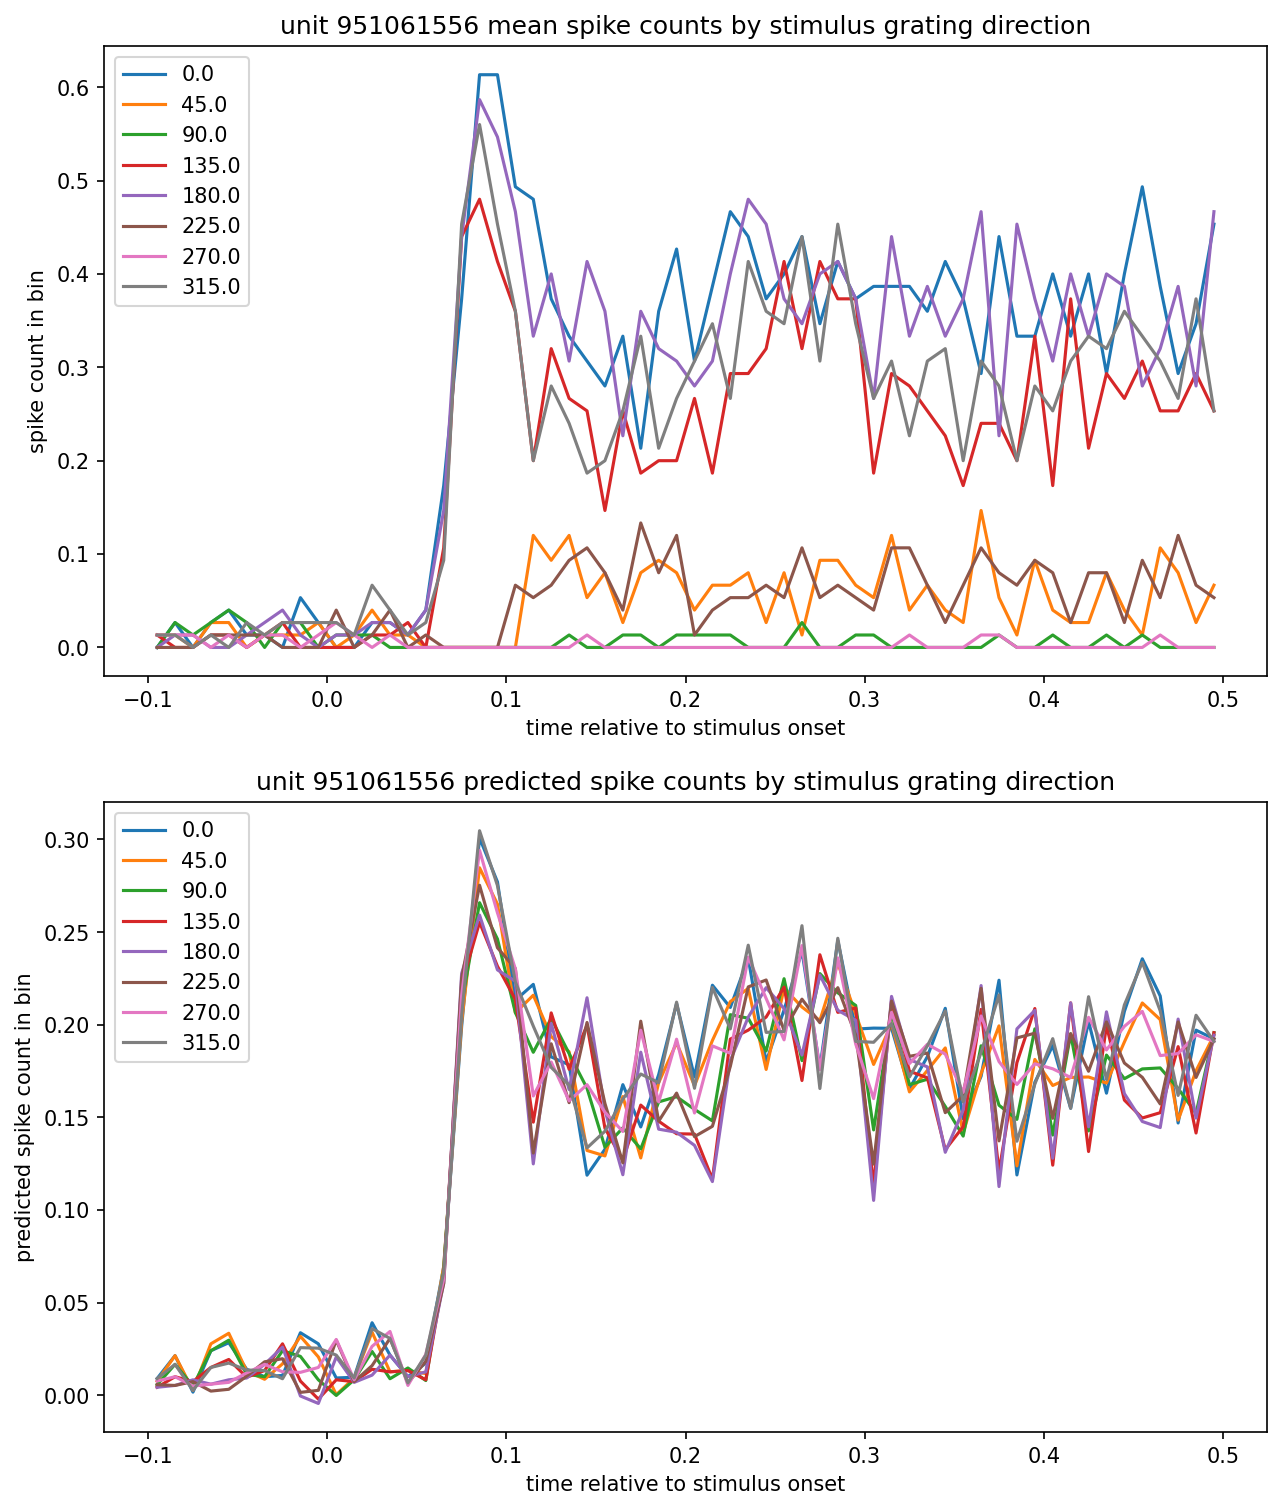

In [47]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


pred_responses = []
for res in sin_cos_results:
    pred_responses.append(res.predict(get_sines_cosines_from_orientations(unique_orientations)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# stimulus-based regression + autoregression with fixed weights per time bin

## stimulus + 1 time bin back

In [95]:
def get_X_auto_reg(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.stack([orientations, spikes[:, i-1]]).T

X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    if i >= 1:
        X_train_i = get_X_auto_reg(spikes_train, orientations_train, i)
        X_test_i = get_X_auto_reg(spikes_test, orientations_test, i)
        Y_train_i = spikes_train[:, i]
        Y_test_i = spikes_test[:, i]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.array(X_train).reshape(-1, 2)
X_test = np.array(X_test).reshape(-1, 2)
Y_train = np.array(Y_train).reshape(-1, 1)
Y_test = np.array(Y_test).reshape(-1, 1)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

In [96]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.3390309852961072
Test Score: 0.31961728527890965


Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction + autoregression, fixed weight')

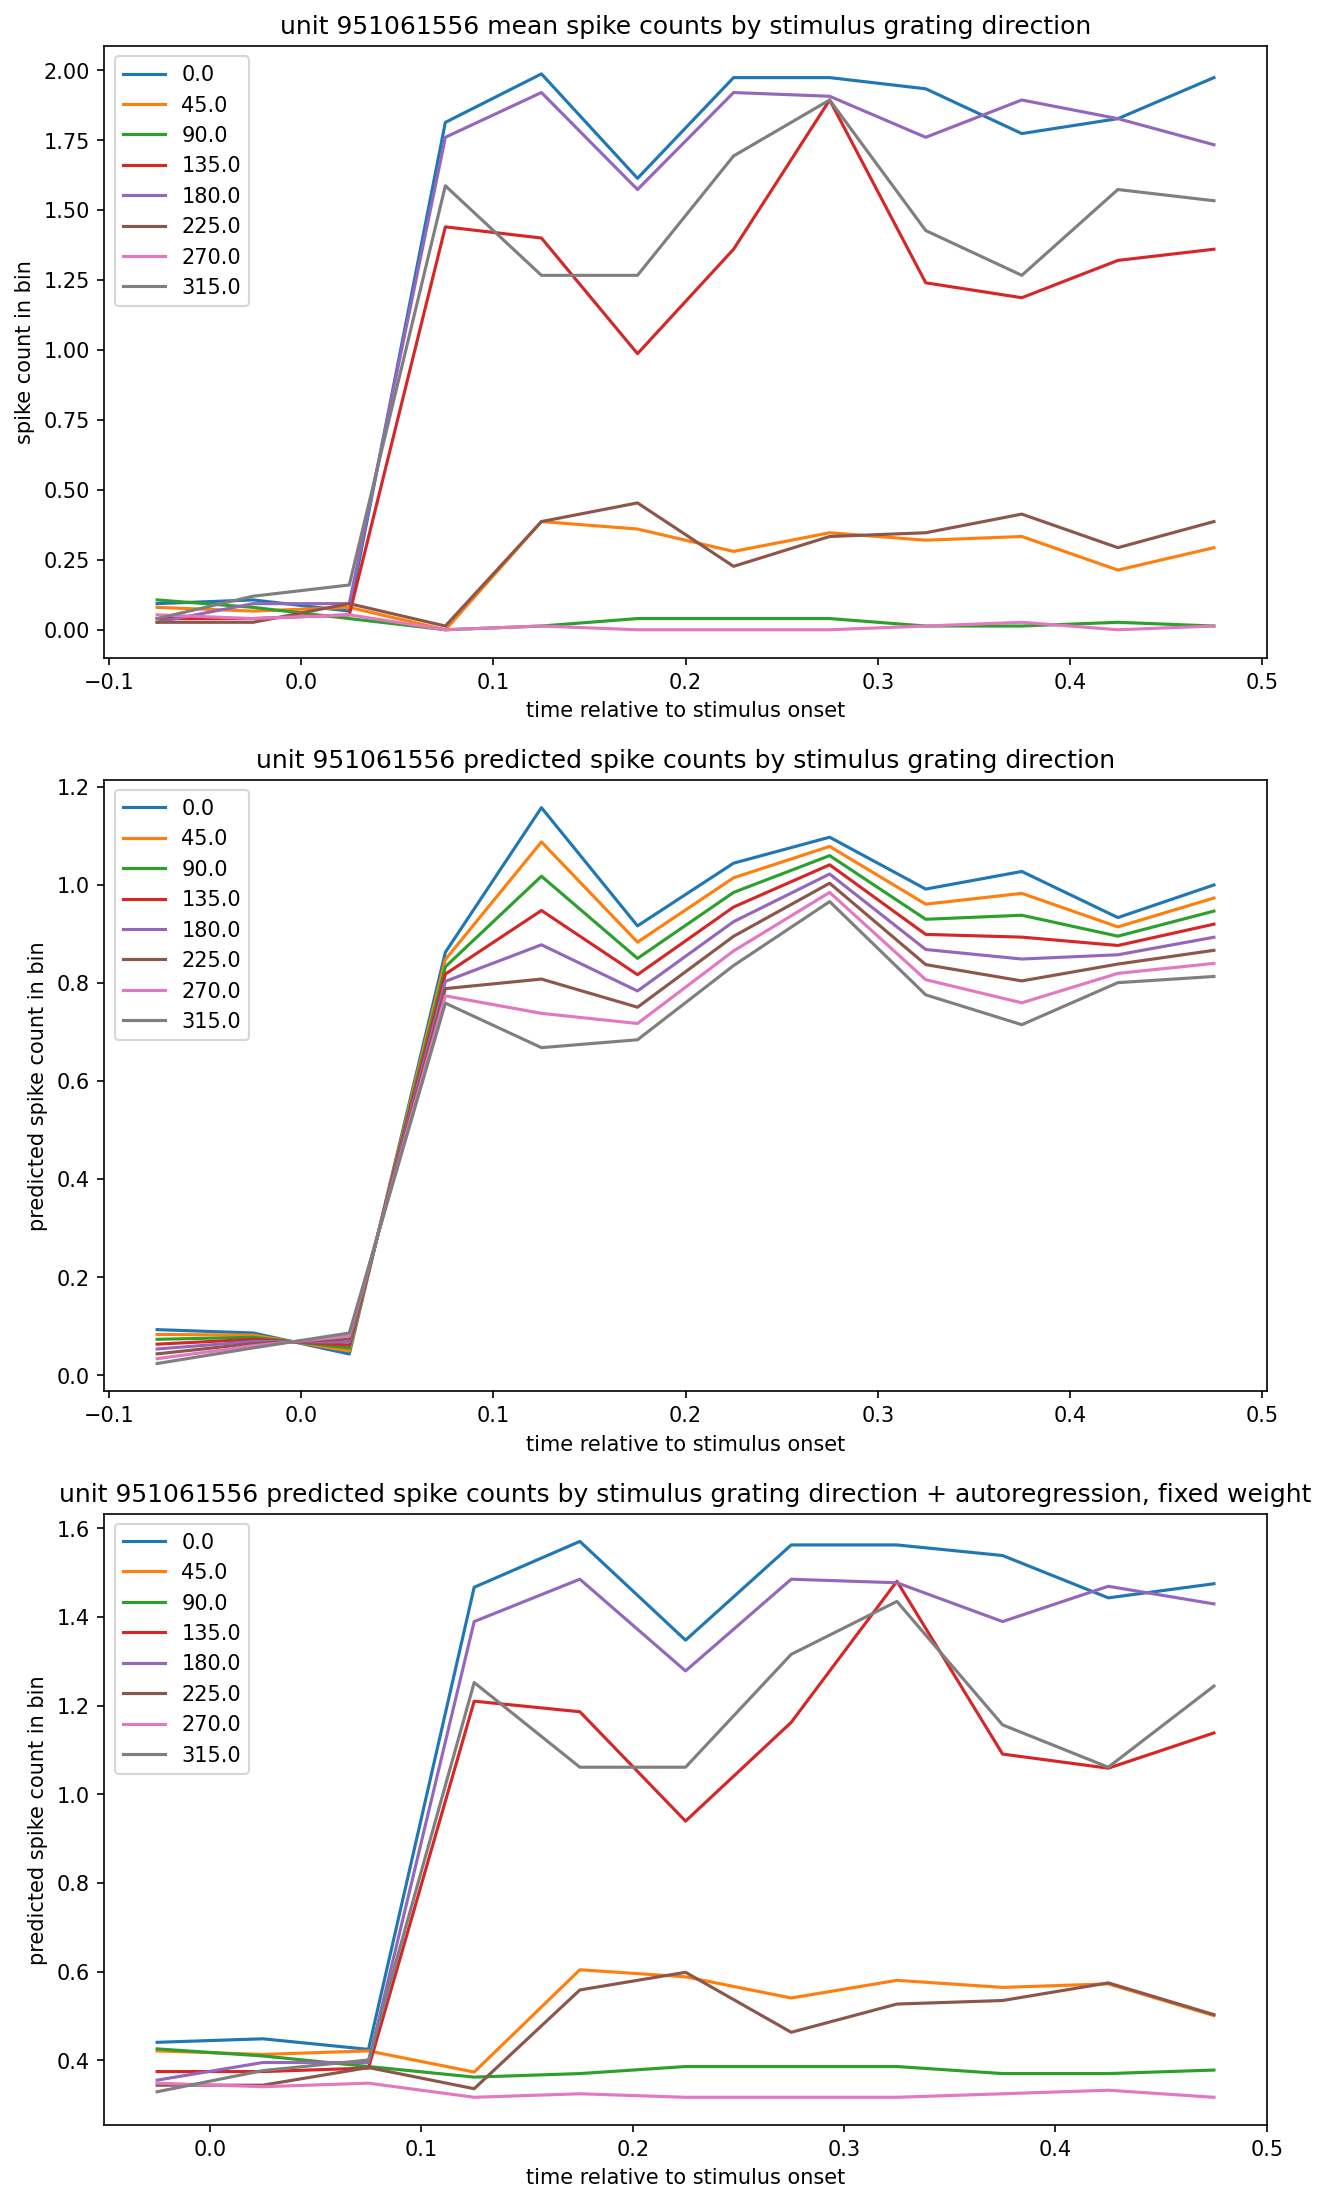

In [102]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), spikes_train.shape[1]-1))
for i in range(spikes_train.shape[1]-1):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = spikes.loc[trial_ids, :, unit_id]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg(data, orientations, time_bin_idx)
        Y = reg.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression, fixed weight")

observation: the model shared weights performs similarly well with time-varying weight models

## longer history

In [111]:
def get_X_auto_reg(spikes, orientations, i, T):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
        T: total lag
    """
    orientations = np.expand_dims(orientations, axis=1)
    return np.concatenate([orientations, spikes[:, i-T:i]], axis=1)


auto_reg_fixed_weights_fits = []
train_scores = []
test_scores = []

for T in range(1, 10):
    print(f'fitting model of lag {T}')
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= T:
            X_train_i = get_X_auto_reg(spikes_train, orientations_train, i, T)
            X_test_i = get_X_auto_reg(spikes_test, orientations_test, i, T)
            Y_train_i = spikes_train[:, i]
            Y_test_i = spikes_test[:, i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, T+1)
    X_test = np.array(X_test).reshape(-1, T+1)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    auto_reg_fixed_weights_fits.append(reg)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    # evaluate bin index [T: )
    train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
    test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))
    train_scores.append(train_score)
    test_scores.append(test_score)

fitting model of lag 1
fitting model of lag 2
fitting model of lag 3
fitting model of lag 4
fitting model of lag 5
fitting model of lag 6
fitting model of lag 7
fitting model of lag 8
fitting model of lag 9


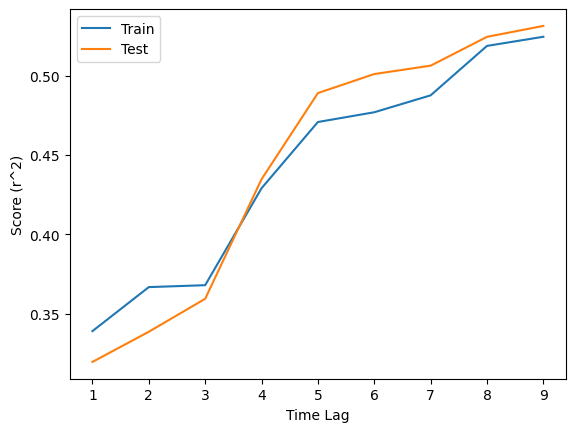

In [112]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), train_scores, label="Train")
ax.plot(range(1, 10), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score (r^2)")
ax.legend()

## check regression coefficients

In [120]:
model_lag = 1
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
print(f'lag-{model_lag} model coefficients')
print(f' {reg_model.coef_[0, 1:]}')

model_lag = 5
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
print(f'lag-{model_lag} model coefficients')
print(f' {reg_model.coef_[0, 1:]}')

lag-1 model coefficients
 [0.59690098]
lag-5 model coefficients
 [0.00999872 0.14720429 0.19181358 0.21902063 0.28316707]


# Models with activities from other neurons

In [20]:
# using the list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
target_unit_id = 951061556

presentations.index.values
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)

orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = spikes.loc[train_idxs, :, interesting_units].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = spikes.loc[test_idxs, :, interesting_units].values

## stimulus + 1 time bin back

In [21]:
def get_X_auto_reg_population(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.concatenate([orientations[:, None], spikes[:, i-1, :]], axis=1)

X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    if i >= 1:
        X_train_i = get_X_auto_reg_population(spikes_train, orientations_train, i)
        X_test_i = get_X_auto_reg_population(spikes_test, orientations_test, i)
        Y_train_i = spikes_train[:, i, 0]
        Y_test_i = spikes_test[:, i, 0]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.array(X_train).reshape(-1, spikes_train.shape[2]+1)
X_test = np.array(X_test).reshape(-1, spikes_train.shape[2]+1)
Y_train = np.array(Y_train).reshape(-1, 1)
Y_test = np.array(Y_test).reshape(-1, 1)

print(X_train.shape)
print(Y_train.shape)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

(5280, 7)
(5280, 1)


In [22]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.3500153671455981
Test Score: 0.32612600316033336


Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction + autoregression + population, fixed weight')

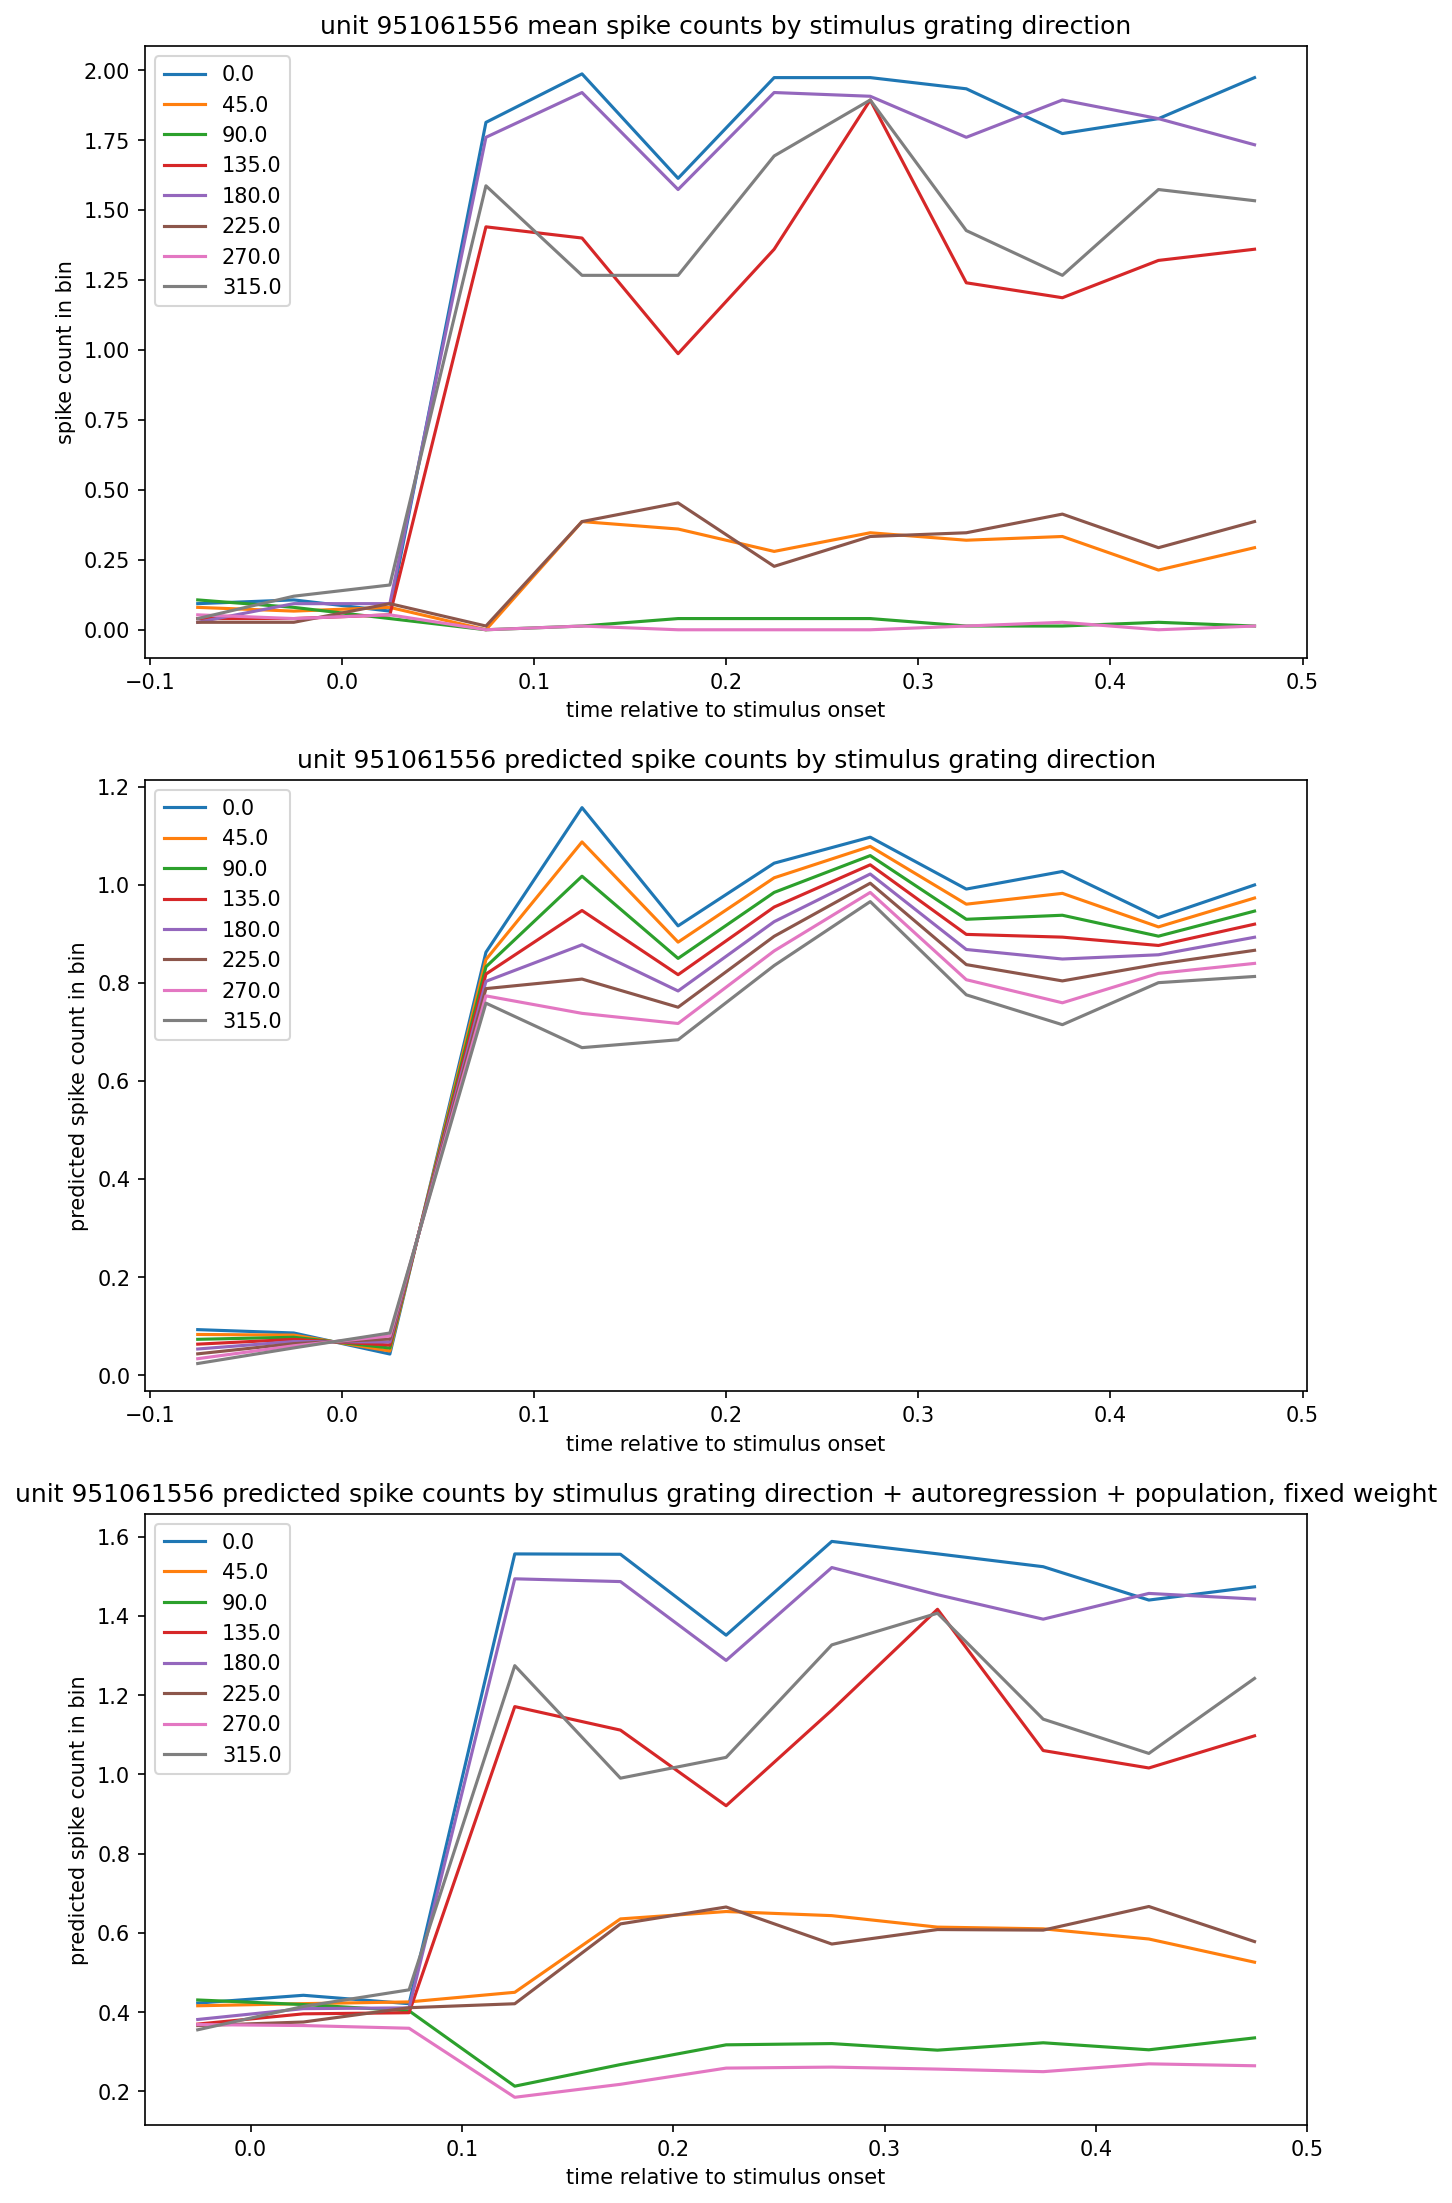

In [23]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = spikes.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), spikes_train.shape[1]-1))
for i in range(spikes_train.shape[1]-1):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = spikes.loc[trial_ids, :, interesting_units]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg_population(data, orientations, time_bin_idx)
        Y = reg.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression + population, fixed weight")

## check influence from other neurons

In [29]:
print(f'target_unit: {target_unit_id}')
for i, unit in enumerate(interesting_units):
    print(f' unit {unit} coeff: {reg.coef_[0, i+1]}')


target_unit: 951061556
 unit 951061556 coeff: 0.5756899598723372
 unit 951061574 coeff: 0.005059117773624333
 unit 951061715 coeff: -0.059447431971149815
 unit 951061906 coeff: 0.07031319059286004
 unit 951061918 coeff: 0.05136750903213633
 unit 951061957 coeff: 0.1679648885438938
